adapted/shamelessly stolen from https://nextjournal.com/gkoehler/pytorch-mnist

First we import all the libraries we need (make sure they're installed of course - we also do some separate imports of submodules for more legible code)

In [111]:
%matplotlib inline

import torch, torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Here we define our hyperparams:

In [112]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

Next we import our training and test data into 'dataloaders', the construct pytorch uses to feed its models inputs efficiently. Note that data_folder should reflect an existing folder in your working directory, and if you haven't downloaded the data yet, you should add a `download = True` option to the two calls to datasets.EMNIST

The Normalize() call is used to normalize the inputs to the mean and stdv of the MNIST (and by extension, EMNIST) dataset - values are taken from the website mentioned above.

Note we're only using the 'letters' split here, but [you can change that to look at other parts, or all, of the EMNIST dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset), just change the `split` option to another string.

In [129]:
data_folder = 'datasets'
split = 'letters' #other options include 'byclass', 'digits' and 'MNIST'

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST(data_folder, train=True, split=split,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST(data_folder, train=False, split=split,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Let's load some examples! the pytorch dataloaders are iterators, so we can use `enumerate()` with them.

In [132]:
examples = enumerate(test_loader)

And now we can rerun this cell to generate some examples!

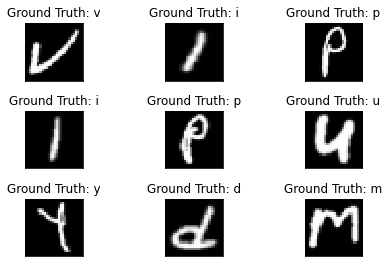

In [139]:

batch_idx, (example_data, example_targets) = next(examples)
example_target_letters = [chr(ord('`')+number) for number in example_targets] 
#this coverts the digits 0-25 to the letters a-z for our figure

fig = plt.figure()

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].T, cmap='gray', interpolation='none')
  # note the '.T' transpose (https://docs.scipy.org/doc/numpy-1.5.x/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T)
  # this is done here because otherwise the images are sideways (not a problem for our network, but looks bad in our figure!)
  plt.title("Ground Truth: {}".format(example_target_letters[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

Alright, we've got the data prepped and ready, time to make a network to classify it!
- First we create Net as a child class of nn.Module (the base class for all neural networks)
- Then we define the layers it has. In this case, two convolutional layers, a dropout layer, and two linear layers.
(note that each layer's output dimension fits with the next layer's input, and the final layer has as many outputs as we have classes - in our case, 26 letters)
- Then we define the `forward(self,x)` method of the Net class, which tells the network how to move the inputs through its net to generate output. Here we also define our output nonlinearity; softmax makes sense since we're classifiying categorical data!

In [142]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100,26)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Time to create an instance of our class, and define the optimizer we're using (you can try to change some stuff here!)

In [150]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

#tell network to use gpu if it can
if torch.cuda.is_available:
    network.cuda()

Alright, network has been initialized, let's get to training! To keep track of the process we create some empty arrays:

In [151]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

and we define two functions that take care of training/testing AND store the results in those arrays we defined above. This basically works as follows. For each batch in `train_loader`:

- move the data to your gpu (if using cuda - otherwise keep using the cpu)
- reset your optimizer (clear out gradients from the last batch)
- attempt to classify the batch of data
- get the loss/difference between ground truth and classification
- backpropagate the loss through the network to calculate the gradients (this is done through the `backward()` method of the loss object, which follows the reverse path of the `forward()` function we defined for our network earlier)
- take a step in the direction of the gradients with your optimizer
- document our network's performance/loss etc

then for test, similarly:

- move the data to your gpu, if using
- classify the data
- get the loss
- report the loss, accuracy etc

These functions also save the state of the network to a folder called results: check that you have a folder named that in your working directory, and make one if you don't.

In [152]:
def train(epoch):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')
    
def test():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Now that we've defined the functions, we can run them! (this will take a while, especially if you're using your cpu)

In [153]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 3.2627, Accuracy: 847/20800 (4%)

Train Epoch: 1 [0/124800 (0%)]	Loss: 3.270169
Train Epoch: 1 [640/124800 (1%)]	Loss: 3.291300
Train Epoch: 1 [1280/124800 (1%)]	Loss: 3.239623
Train Epoch: 1 [1920/124800 (2%)]	Loss: 3.236048
Train Epoch: 1 [2560/124800 (2%)]	Loss: 3.263952
Train Epoch: 1 [3200/124800 (3%)]	Loss: 3.257486
Train Epoch: 1 [3840/124800 (3%)]	Loss: 3.267380
Train Epoch: 1 [4480/124800 (4%)]	Loss: 3.213031
Train Epoch: 1 [5120/124800 (4%)]	Loss: 3.259892
Train Epoch: 1 [5760/124800 (5%)]	Loss: 3.235950
Train Epoch: 1 [6400/124800 (5%)]	Loss: 3.246479
Train Epoch: 1 [7040/124800 (6%)]	Loss: 3.246183
Train Epoch: 1 [7680/124800 (6%)]	Loss: 3.189900
Train Epoch: 1 [8320/124800 (7%)]	Loss: 3.129929
Train Epoch: 1 [8960/124800 (7%)]	Loss: 3.177922
Train Epoch: 1 [9600/124800 (8%)]	Loss: 3.130292
Train Epoch: 1 [10240/124800 (8%)]	Loss: 3.112736
Train Epoch: 1 [10880/124800 (9%)]	Loss: 3.071281
Train Epoch: 1 [11520/124800 (9%)]	Loss: 3.022408
Train Epoch: 1

Train Epoch: 1 [103680/124800 (83%)]	Loss: 1.648816
Train Epoch: 1 [104320/124800 (84%)]	Loss: 1.560593
Train Epoch: 1 [104960/124800 (84%)]	Loss: 1.427431
Train Epoch: 1 [105600/124800 (85%)]	Loss: 1.327602
Train Epoch: 1 [106240/124800 (85%)]	Loss: 1.427207
Train Epoch: 1 [106880/124800 (86%)]	Loss: 1.372847
Train Epoch: 1 [107520/124800 (86%)]	Loss: 1.595181
Train Epoch: 1 [108160/124800 (87%)]	Loss: 1.440748
Train Epoch: 1 [108800/124800 (87%)]	Loss: 1.291697
Train Epoch: 1 [109440/124800 (88%)]	Loss: 1.370196
Train Epoch: 1 [110080/124800 (88%)]	Loss: 1.436193
Train Epoch: 1 [110720/124800 (89%)]	Loss: 1.326437
Train Epoch: 1 [111360/124800 (89%)]	Loss: 1.566415
Train Epoch: 1 [112000/124800 (90%)]	Loss: 1.444414
Train Epoch: 1 [112640/124800 (90%)]	Loss: 1.548246
Train Epoch: 1 [113280/124800 (91%)]	Loss: 1.475182
Train Epoch: 1 [113920/124800 (91%)]	Loss: 1.422931
Train Epoch: 1 [114560/124800 (92%)]	Loss: 1.234239
Train Epoch: 1 [115200/124800 (92%)]	Loss: 1.763551
Train Epoch:

Train Epoch: 2 [81280/124800 (65%)]	Loss: 1.230874
Train Epoch: 2 [81920/124800 (66%)]	Loss: 0.771473
Train Epoch: 2 [82560/124800 (66%)]	Loss: 1.225440
Train Epoch: 2 [83200/124800 (67%)]	Loss: 1.158981
Train Epoch: 2 [83840/124800 (67%)]	Loss: 1.113006
Train Epoch: 2 [84480/124800 (68%)]	Loss: 1.433906
Train Epoch: 2 [85120/124800 (68%)]	Loss: 1.247382
Train Epoch: 2 [85760/124800 (69%)]	Loss: 1.046709
Train Epoch: 2 [86400/124800 (69%)]	Loss: 1.004133
Train Epoch: 2 [87040/124800 (70%)]	Loss: 1.127239
Train Epoch: 2 [87680/124800 (70%)]	Loss: 0.891026
Train Epoch: 2 [88320/124800 (71%)]	Loss: 1.329247
Train Epoch: 2 [88960/124800 (71%)]	Loss: 1.167388
Train Epoch: 2 [89600/124800 (72%)]	Loss: 1.028454
Train Epoch: 2 [90240/124800 (72%)]	Loss: 0.728634
Train Epoch: 2 [90880/124800 (73%)]	Loss: 0.961948
Train Epoch: 2 [91520/124800 (73%)]	Loss: 1.221397
Train Epoch: 2 [92160/124800 (74%)]	Loss: 1.209478
Train Epoch: 2 [92800/124800 (74%)]	Loss: 1.284438
Train Epoch: 2 [93440/124800 (7

Train Epoch: 3 [58880/124800 (47%)]	Loss: 0.888614
Train Epoch: 3 [59520/124800 (48%)]	Loss: 0.984741
Train Epoch: 3 [60160/124800 (48%)]	Loss: 0.941616
Train Epoch: 3 [60800/124800 (49%)]	Loss: 1.007389
Train Epoch: 3 [61440/124800 (49%)]	Loss: 0.994704
Train Epoch: 3 [62080/124800 (50%)]	Loss: 1.198727
Train Epoch: 3 [62720/124800 (50%)]	Loss: 1.273381
Train Epoch: 3 [63360/124800 (51%)]	Loss: 0.750155
Train Epoch: 3 [64000/124800 (51%)]	Loss: 0.852301
Train Epoch: 3 [64640/124800 (52%)]	Loss: 1.049113
Train Epoch: 3 [65280/124800 (52%)]	Loss: 0.793506
Train Epoch: 3 [65920/124800 (53%)]	Loss: 0.700420
Train Epoch: 3 [66560/124800 (53%)]	Loss: 1.041306
Train Epoch: 3 [67200/124800 (54%)]	Loss: 1.004790
Train Epoch: 3 [67840/124800 (54%)]	Loss: 1.230626
Train Epoch: 3 [68480/124800 (55%)]	Loss: 0.799536
Train Epoch: 3 [69120/124800 (55%)]	Loss: 1.022276
Train Epoch: 3 [69760/124800 (56%)]	Loss: 0.896870
Train Epoch: 3 [70400/124800 (56%)]	Loss: 1.079713
Train Epoch: 3 [71040/124800 (5

83% accuracy after three epochs! Not bad! How did training progress? let's plot some of that progress we saved earlier.

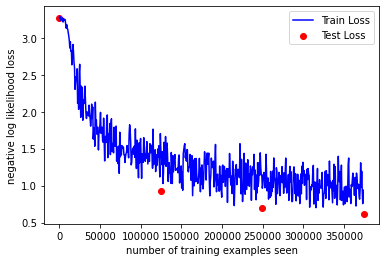

In [156]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

Nice, pretty smooth training and no overfitting (yet). Let's look at some examples and how our network classified them.

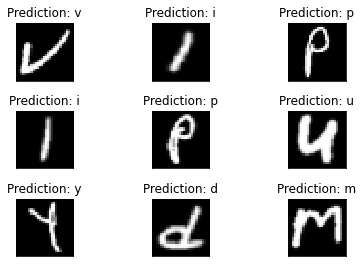

In [158]:
device = torch.device("cuda:0" if use_cuda else "cpu")
with torch.no_grad():
  output = network(example_data.to(device))

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].T, cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    chr(ord('`')+output.data.max(1, keepdim=True)[1][i].item())))
  plt.xticks([])
  plt.yticks([])
    
plt.show()

Nice, it actually learned how to classify these pretty well (although it still makes a lot of mistakes elsewhere of course, as we can tell from the accuracy)

If we now want to train our network more, we can just call the functions some more - or you can load network conditions from a saved file. Let's see how that works: first we define a network again.

In [159]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

And now we load the properties of the network we just saved.

In [160]:
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Now, we can just continue to train our network! Of course in this case this doesn't add much, but this is useful if you want to continue training at a later date, for example, or make snapshots of your network.

In [161]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/124800 (0%)]	Loss: 0.861178
Train Epoch: 4 [640/124800 (1%)]	Loss: 1.241347
Train Epoch: 4 [1280/124800 (1%)]	Loss: 1.084444
Train Epoch: 4 [1920/124800 (2%)]	Loss: 1.155968
Train Epoch: 4 [2560/124800 (2%)]	Loss: 1.017312
Train Epoch: 4 [3200/124800 (3%)]	Loss: 0.866707
Train Epoch: 4 [3840/124800 (3%)]	Loss: 1.095472
Train Epoch: 4 [4480/124800 (4%)]	Loss: 0.854348
Train Epoch: 4 [5120/124800 (4%)]	Loss: 1.071491
Train Epoch: 4 [5760/124800 (5%)]	Loss: 0.860137
Train Epoch: 4 [6400/124800 (5%)]	Loss: 0.867430
Train Epoch: 4 [7040/124800 (6%)]	Loss: 1.568944
Train Epoch: 4 [7680/124800 (6%)]	Loss: 0.824364
Train Epoch: 4 [8320/124800 (7%)]	Loss: 0.797803
Train Epoch: 4 [8960/124800 (7%)]	Loss: 1.107725
Train Epoch: 4 [9600/124800 (8%)]	Loss: 0.780420
Train Epoch: 4 [10240/124800 (8%)]	Loss: 1.200595
Train Epoch: 4 [10880/124800 (9%)]	Loss: 1.364869
Train Epoch: 4 [11520/124800 (9%)]	Loss: 0.762346
Train Epoch: 4 [12160/124800 (10%)]	Loss: 1.102689
Train Epoch: 4 [128

Train Epoch: 4 [104320/124800 (84%)]	Loss: 0.905200
Train Epoch: 4 [104960/124800 (84%)]	Loss: 0.811464
Train Epoch: 4 [105600/124800 (85%)]	Loss: 0.887697
Train Epoch: 4 [106240/124800 (85%)]	Loss: 0.940689
Train Epoch: 4 [106880/124800 (86%)]	Loss: 0.800951
Train Epoch: 4 [107520/124800 (86%)]	Loss: 1.104488
Train Epoch: 4 [108160/124800 (87%)]	Loss: 0.941307
Train Epoch: 4 [108800/124800 (87%)]	Loss: 0.983788
Train Epoch: 4 [109440/124800 (88%)]	Loss: 1.192820
Train Epoch: 4 [110080/124800 (88%)]	Loss: 0.963103
Train Epoch: 4 [110720/124800 (89%)]	Loss: 1.031245
Train Epoch: 4 [111360/124800 (89%)]	Loss: 0.923959
Train Epoch: 4 [112000/124800 (90%)]	Loss: 0.636695
Train Epoch: 4 [112640/124800 (90%)]	Loss: 1.138440
Train Epoch: 4 [113280/124800 (91%)]	Loss: 0.856339
Train Epoch: 4 [113920/124800 (91%)]	Loss: 0.997160
Train Epoch: 4 [114560/124800 (92%)]	Loss: 0.972750
Train Epoch: 4 [115200/124800 (92%)]	Loss: 0.736955
Train Epoch: 4 [115840/124800 (93%)]	Loss: 0.843959
Train Epoch:

Train Epoch: 5 [82560/124800 (66%)]	Loss: 0.748227
Train Epoch: 5 [83200/124800 (67%)]	Loss: 0.893982
Train Epoch: 5 [83840/124800 (67%)]	Loss: 0.795431
Train Epoch: 5 [84480/124800 (68%)]	Loss: 1.057391
Train Epoch: 5 [85120/124800 (68%)]	Loss: 0.888181
Train Epoch: 5 [85760/124800 (69%)]	Loss: 0.631235
Train Epoch: 5 [86400/124800 (69%)]	Loss: 0.883911
Train Epoch: 5 [87040/124800 (70%)]	Loss: 0.857340
Train Epoch: 5 [87680/124800 (70%)]	Loss: 0.593656
Train Epoch: 5 [88320/124800 (71%)]	Loss: 0.745192
Train Epoch: 5 [88960/124800 (71%)]	Loss: 0.695250
Train Epoch: 5 [89600/124800 (72%)]	Loss: 1.051916
Train Epoch: 5 [90240/124800 (72%)]	Loss: 0.841491
Train Epoch: 5 [90880/124800 (73%)]	Loss: 1.506562
Train Epoch: 5 [91520/124800 (73%)]	Loss: 0.802408
Train Epoch: 5 [92160/124800 (74%)]	Loss: 0.875513
Train Epoch: 5 [92800/124800 (74%)]	Loss: 0.831356
Train Epoch: 5 [93440/124800 (75%)]	Loss: 0.906570
Train Epoch: 5 [94080/124800 (75%)]	Loss: 1.115981
Train Epoch: 5 [94720/124800 (7

Train Epoch: 6 [60160/124800 (48%)]	Loss: 0.692487
Train Epoch: 6 [60800/124800 (49%)]	Loss: 1.045788
Train Epoch: 6 [61440/124800 (49%)]	Loss: 0.918534
Train Epoch: 6 [62080/124800 (50%)]	Loss: 0.921258
Train Epoch: 6 [62720/124800 (50%)]	Loss: 0.900824
Train Epoch: 6 [63360/124800 (51%)]	Loss: 1.114717
Train Epoch: 6 [64000/124800 (51%)]	Loss: 0.718126
Train Epoch: 6 [64640/124800 (52%)]	Loss: 0.685670
Train Epoch: 6 [65280/124800 (52%)]	Loss: 0.971152
Train Epoch: 6 [65920/124800 (53%)]	Loss: 0.916092
Train Epoch: 6 [66560/124800 (53%)]	Loss: 0.723728
Train Epoch: 6 [67200/124800 (54%)]	Loss: 0.790513
Train Epoch: 6 [67840/124800 (54%)]	Loss: 0.759629
Train Epoch: 6 [68480/124800 (55%)]	Loss: 0.975592
Train Epoch: 6 [69120/124800 (55%)]	Loss: 0.818449
Train Epoch: 6 [69760/124800 (56%)]	Loss: 0.887052
Train Epoch: 6 [70400/124800 (56%)]	Loss: 0.719205
Train Epoch: 6 [71040/124800 (57%)]	Loss: 0.741965
Train Epoch: 6 [71680/124800 (57%)]	Loss: 0.505264
Train Epoch: 6 [72320/124800 (5

Train Epoch: 7 [38400/124800 (31%)]	Loss: 0.694872
Train Epoch: 7 [39040/124800 (31%)]	Loss: 0.557683
Train Epoch: 7 [39680/124800 (32%)]	Loss: 0.941355
Train Epoch: 7 [40320/124800 (32%)]	Loss: 0.749555
Train Epoch: 7 [40960/124800 (33%)]	Loss: 0.795971
Train Epoch: 7 [41600/124800 (33%)]	Loss: 0.674197
Train Epoch: 7 [42240/124800 (34%)]	Loss: 0.873794
Train Epoch: 7 [42880/124800 (34%)]	Loss: 0.829704
Train Epoch: 7 [43520/124800 (35%)]	Loss: 0.749862
Train Epoch: 7 [44160/124800 (35%)]	Loss: 0.656250
Train Epoch: 7 [44800/124800 (36%)]	Loss: 0.813004
Train Epoch: 7 [45440/124800 (36%)]	Loss: 0.768156
Train Epoch: 7 [46080/124800 (37%)]	Loss: 1.063102
Train Epoch: 7 [46720/124800 (37%)]	Loss: 0.598291
Train Epoch: 7 [47360/124800 (38%)]	Loss: 0.810953
Train Epoch: 7 [48000/124800 (38%)]	Loss: 0.935021
Train Epoch: 7 [48640/124800 (39%)]	Loss: 0.744554
Train Epoch: 7 [49280/124800 (39%)]	Loss: 1.053916
Train Epoch: 7 [49920/124800 (40%)]	Loss: 0.641039
Train Epoch: 7 [50560/124800 (4

Train Epoch: 8 [16000/124800 (13%)]	Loss: 0.697677
Train Epoch: 8 [16640/124800 (13%)]	Loss: 0.695403
Train Epoch: 8 [17280/124800 (14%)]	Loss: 0.581825
Train Epoch: 8 [17920/124800 (14%)]	Loss: 0.666275
Train Epoch: 8 [18560/124800 (15%)]	Loss: 0.742845
Train Epoch: 8 [19200/124800 (15%)]	Loss: 0.852647
Train Epoch: 8 [19840/124800 (16%)]	Loss: 0.828537
Train Epoch: 8 [20480/124800 (16%)]	Loss: 0.660044
Train Epoch: 8 [21120/124800 (17%)]	Loss: 0.990058
Train Epoch: 8 [21760/124800 (17%)]	Loss: 0.672642
Train Epoch: 8 [22400/124800 (18%)]	Loss: 0.868360
Train Epoch: 8 [23040/124800 (18%)]	Loss: 0.756889
Train Epoch: 8 [23680/124800 (19%)]	Loss: 0.604986
Train Epoch: 8 [24320/124800 (19%)]	Loss: 0.746115
Train Epoch: 8 [24960/124800 (20%)]	Loss: 1.042536
Train Epoch: 8 [25600/124800 (21%)]	Loss: 0.714418
Train Epoch: 8 [26240/124800 (21%)]	Loss: 0.650160
Train Epoch: 8 [26880/124800 (22%)]	Loss: 0.785082
Train Epoch: 8 [27520/124800 (22%)]	Loss: 0.816165
Train Epoch: 8 [28160/124800 (2

Train Epoch: 8 [119040/124800 (95%)]	Loss: 0.880571
Train Epoch: 8 [119680/124800 (96%)]	Loss: 0.814141
Train Epoch: 8 [120320/124800 (96%)]	Loss: 0.758359
Train Epoch: 8 [120960/124800 (97%)]	Loss: 0.679863
Train Epoch: 8 [121600/124800 (97%)]	Loss: 0.701989
Train Epoch: 8 [122240/124800 (98%)]	Loss: 0.641459
Train Epoch: 8 [122880/124800 (98%)]	Loss: 0.753577
Train Epoch: 8 [123520/124800 (99%)]	Loss: 0.794563
Train Epoch: 8 [124160/124800 (99%)]	Loss: 0.821544

Test set: Avg. loss: 0.4986, Accuracy: 17963/20800 (86%)



Did it learn more, or has training plateaued?

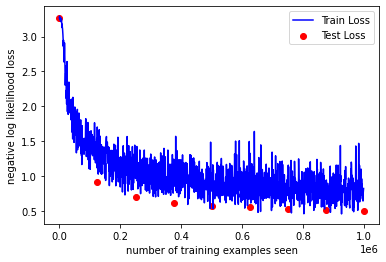

In [163]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

Sure enough, it still improved! (slightly)
Importantly, you can see how training continues smoothly from the state where we loaded the network.

Next steps: Make your own network! Tweak some hyperparameters! Change the optimizer! Try different datasets!